In [1]:
import numpy as np
import scipy as sp
import scipy.special as spec
from sklearn.preprocessing import normalize
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def rho(tau,kappa,t):
    return (tau+t)**(-kappa)

In [3]:
def digamma(row):
    return spec.psi(row)-spec.psi(np.sum(row))

In [113]:
def lda(dtm,ntopic,tau,kappa,itemax):
    nvoc = dtm.shape[1]
    ndoc = dtm.shape[0]
    nu = 1./ndoc
    alpha = 1.
    
    topics = np.random.gamma(100.,1./100.,(nvoc,ntopic))
    phi = np.random.gamma(100.,1./100.,(nvoc,ntopic))
    gamma  = np.random.gamma(100.,1./100.,(ndoc,ntopic))
    
    intint = 100
    idx = range(ndoc)
    idx *= int(float(itemax)/ndoc)
    np.random.shuffle(idx)
    
    
    for t in range(itemax):
        old_topics = topics
        doc = idx[t]
        ids = np.nonzero(dtm[doc,:])[0]
        cts = dtm[doc,ids]
        gamma_ = gamma[doc,:]
        Elogbeta = np.apply_along_axis(digamma, axis=0, arr=topics)[ids,:]
        dott = lambda x: np.dot(x,cts)
        for tt in range(intint):
            old_gamma_ = gamma_
            Elogtheta = digamma(gamma_)
            E_sum = Elogbeta + Elogtheta
            phi = np.exp(E_sum)/np.exp(E_sum).sum(axis=1)[:, np.newaxis]
            gamma_ = alpha + np.apply_along_axis(dott,axis=0,arr=phi)
            if np.sqrt(np.mean((gamma_-old_gamma_)**2))<0.0001:
                break  
        gamma[doc,:] = gamma_
        topics_temp = nu + ndoc * phi * dtm[doc,ids][:, np.newaxis]
        rt = rho(tau,kappa,t)
        topics[ids,:] = (1-rt)*topics[ids,:] + rt*topics_temp
    
    return topics,gamma,tau,kappa

In [135]:
def inference(lda,newdocs,ite):
    alpha = 1
    
    topics = lda[0]
    tau = lda[2]
    kappa = lda[3]
    
    phi = np.random.gamma(100.,1./100.,(topics.shape))
    
    if len(newdocs.shape)==1:
        gamma_new  = np.random.gamma(100.,1./100.,(1,lda[1].shape[1]))
        for it in range(ite):
            ids = np.nonzero(newdocs)[0]
            cts = newdocs[ids]
            gamma_ = gamma_new
            Elogbeta = np.apply_along_axis(digamma, axis=0, arr=topics)[ids,:]
            dott = lambda x: np.dot(x,cts)
            for tt in range(100):
                old_gamma_ = gamma_
                Elogtheta = digamma(gamma_)
                E_sum = Elogbeta + Elogtheta
                phi = np.exp(E_sum)/np.exp(E_sum).sum(axis=1)[:, np.newaxis]
                gamma_ = alpha + np.apply_along_axis(dott,axis=0,arr=phi)
                if np.sqrt(np.mean((gamma_-old_gamma_)**2))<0.0001:
                    break  
            gamma_new = gamma_
            topics_temp = nu +  phi * cts[:, np.newaxis]
            rt = rho(tau,kappa,it)
            topics[ids,:] = (1-rt)*topics[ids,:] + rt*topics_temp
    
    else:
        gamma_new  = np.random.gamma(100.,1./100.,(newdocs.shape[0],lda[1].shape[1]))
        idx = range(newdocs.shape[0])
        idx *= ite
        np.random.shuffle(idx)
        for it in range(len(idx)):
            doc = idx[it]
            ids = np.nonzero(newdocs[doc,:])[0]
            cts = newdocs[doc,ids]
            gamma_ = gamma_new[doc,:]
            Elogbeta = np.apply_along_axis(digamma, axis=0, arr=topics)[ids,:]
            dott = lambda x: np.dot(x,cts)
            for tt in range(100):
                old_gamma_ = gamma_
                Elogtheta = digamma(gamma_)
                E_sum = Elogbeta + Elogtheta
                phi = np.exp(E_sum)/np.exp(E_sum).sum(axis=1)[:, np.newaxis]
                gamma_ = alpha + np.apply_along_axis(dott,axis=0,arr=phi)
                if np.sqrt(np.mean((gamma_-old_gamma_)**2))<0.0001:
                    break  
            gamma_new[doc,:] = gamma_
            topics_temp = nu +  phi * cts[:, np.newaxis]
            rt = rho(tau,kappa,it)
            topics[ids,:] = (1-rt)*topics[ids,:] + rt*topics_temp
            
    return topics,gamma_new

In [145]:
def show_topics(lda,whichtopic,topwords,wordlist):
    topics = lda[0]
    for t in whichtopic:
        idx = np.argsort(t)[::-1][:topwords]
        words  = wordlist[idx]
        print "Topic %s:" % t
        print ""
        print words
        print ""

In [2]:
dtm = np.zeros((100, 100))
dtm_ = np.zeros((10, 100))
for i in range(10):
    dtm_[i,] = [0]*10*i + [10]*10 + [0]*(10*(9-i))
for i in range(10):
    dtm[10*i:10*(i+1),]= dtm_

In [250]:
%%time
test = lda(dtm,10,10,0.5,300)

CPU times: user 268 ms, sys: 3.46 ms, total: 271 ms
Wall time: 281 ms


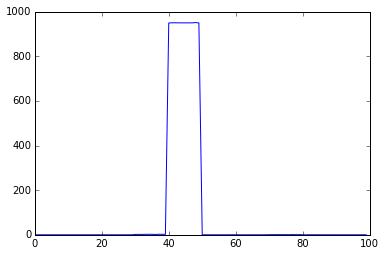

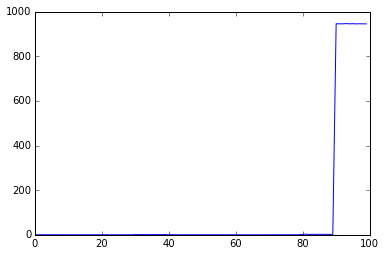

In [101]:
for i in range(2):
    plt.plot(range(100),test[0][:,i])
    plt.show()
    raw_input()
    

In [63]:
new_doc = [0]*100
new_doc[:10] = [5]*10
new_doc[90:] = [5]*10
new_doc = np.array(new_doc)

In [136]:
test2 = inference(test,new_doc,3)

In [137]:
test2[1]

array([  1.00016538,   1.00205872,   1.00006296,  50.99974546,
         1.        ,  50.99794627,   1.        ,   1.00000019,
         1.00000194,   1.00001908])

In [140]:
new_docs = np.zeros((2,100))
new_docs[0,:10] = [5]*10
new_docs[0,90:] = [5]*10
new_docs[1,10:20] = [5]*10
new_docs[1,80:90] = [5]*10

In [142]:
test3 = inference(test,new_docs,3)

In [192]:
def perplexity_train(lda,dtm,docs_id):
    
    topics = lda[0]/lda[0].sum(axis=0)
    gammas = lda[1]/lda[1].sum(axis=1)[:, np.newaxis]
    
    if isinstance(docs_id, int) or len(docs_id) == 1:
        doc_idx = np.nonzero(dtm[docs_id,:])[0]
        doc_cts = dtm[docs_id,doc_idx]
        return np.exp(-np.log(np.sum(np.dot(topics[doc_idx,:],gammas[docs_id,:])*doc_cts))/np.sum(doc_cts))
    
    else:
        num = 0
        denom = 0
        
        for i in docs_id:
            doc_idx = np.nonzero(dtm[i,:])[0]
            doc_cts = dtm[docs_id,doc_idx]
            num -= np.log(np.sum(np.dot(topics[doc_idx,:],gammas[i,:])*doc_cts))
            denom += np.sum(doc_cts)
            
        return np.exp(num/denom)

In [204]:
def perplexity_test(lda,newdocs,ite):
    
    new = inference(lda,newdocs,ite)
    
    topics = new[0]
    gammas = new[1]
    
    topics = topics/topics.sum(axis=0)
    
    if len(gammas.shape) == 1:
        gammas = gammas/np.sum(gammas)
        doc_idx = np.nonzero(newdocs)[0]
        doc_cts = newdocs[doc_idx]
        return np.exp(-np.log(np.sum(np.dot(topics[doc_idx,:],gammas)*doc_cts))/np.sum(doc_cts))
    
    else:
        gammas = gammas/gammas.sum(axis=1)[:, np.newaxis]
        
        num = 0
        denom = 0
        
        for i in range(gammas.shape[0]):
            doc_idx = np.nonzero(newdocs[i,:])[0]
            doc_cts = newdocs[i,doc_idx]
            num -= np.log(np.sum(np.dot(topics[doc_idx,:],gammas[i,:])*doc_cts))
            denom += np.sum(doc_cts)
            
        return np.exp(num/denom)

In [264]:
nvoc = corpus.shape[1]
ndoc = corpus.shape[0]
nu = 1./ndoc
alpha = 1.
    
topics = np.random.gamma(100.,1./100.,(nvoc,ntopic))
phi = np.random.gamma(100.,1./100.,(nvoc,ntopic))
gamma  = np.random.gamma(100.,1./100.,(ndoc,ntopic))
    
intint = 100
idx = range(ndoc)
idx *= int(float(itemax)/ndoc)
np.random.shuffle(idx)
minibatchesids = np.array_split(idx,len(idx)/10)

In [267]:
minibatchesids[10]

array([72, 14, 28, 66, 88, 48,  6, 51, 51, 70])

In [6]:
def lda_minibatch(dtm,ntopic,mb_size,tau,kappa,itemax):
    nvoc = dtm.shape[1]
    ndoc = dtm.shape[0]
    nu = 1./ndoc
    alpha = 1.
    
    topics = np.random.gamma(100.,1./100.,(nvoc,ntopic))
    phi = np.random.gamma(100.,1./100.,(nvoc,ntopic))
    gamma  = np.random.gamma(100.,1./100.,(ndoc,ntopic))
    
    intint = 100
    idx = range(ndoc)
    #np.random.shuffle(idx)
    idx *= itemax
    #np.random.shuffle(idx)
    minibatchesids = np.array_split(idx,len(idx)/mb_size)
    
    for t in range(len(minibatchesids)):
        topics_temp = np.zeros(topics.shape)
        indices = []
        
        for id_ in minibatchesids[t]:
            doc = idx[id_]
            ids = np.nonzero(dtm[doc,:])[0]
            indices.extend(ids)
            cts = dtm[doc,ids]
            gamma_ = gamma[doc,:]
            Elogbeta = np.apply_along_axis(digamma, axis=0, arr=topics)[ids,:]
            dott = lambda x: np.dot(x,cts)
            
            for tt in range(intint):
                old_gamma_ = gamma_
                Elogtheta = digamma(gamma_)
                E_sum = Elogbeta + Elogtheta
                phi = np.exp(E_sum)/np.exp(E_sum).sum(axis=1)[:, np.newaxis]
                gamma_ = alpha + np.apply_along_axis(dott,axis=0,arr=phi)
                if np.sqrt(np.mean((gamma_-old_gamma_)**2))<0.000001:
                    break  
            gamma[doc,:] = gamma_
            topics_temp[ids,:] += phi * dtm[doc,ids][:, np.newaxis]
            
        indices  = np.unique(indices)
        topics_temp[indices,:] = nu + (ndoc/len(minibatchesids[t])) * topics_temp[indices,:]
        rt = rho(tau,kappa,t)
        topics[indices ,:] = (1-rt)*topics[indices,:] + rt*topics_temp[indices,:]
    
    return topics,gamma,tau,kappa

In [17]:
%%time
test5 = lda_minibatch(corpus,9,1,512,0.9,100)

CPU times: user 10.8 s, sys: 96.6 ms, total: 10.9 s
Wall time: 11.1 s


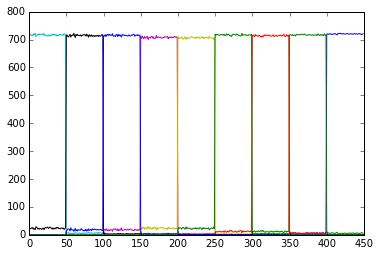

In [18]:
for i in range(9):
    plt.plot(range(450),test5[0][:,i])
plt.show()

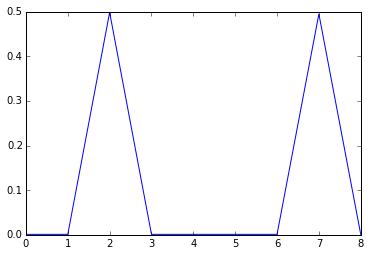

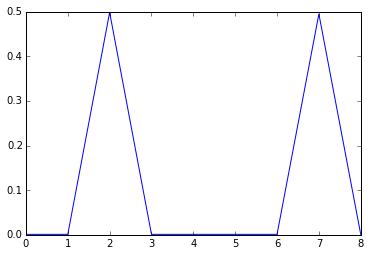

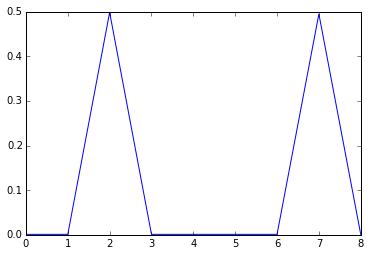

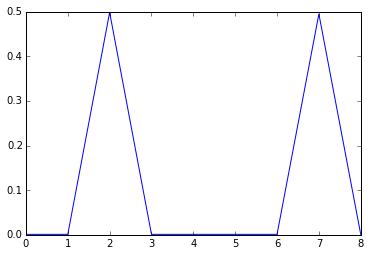

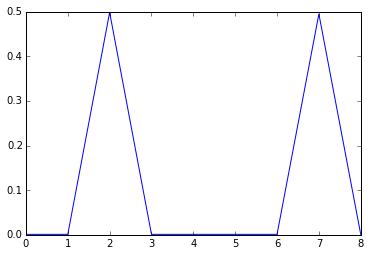

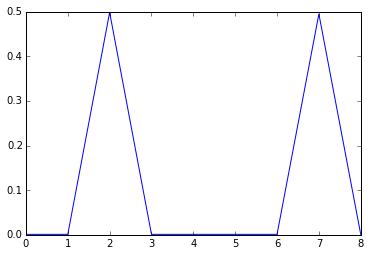

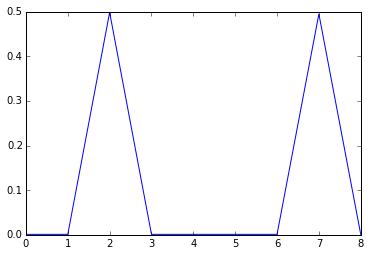

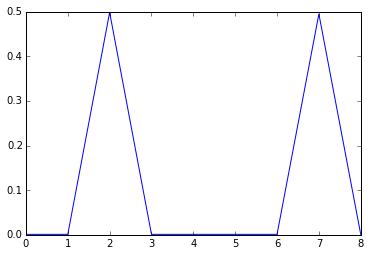

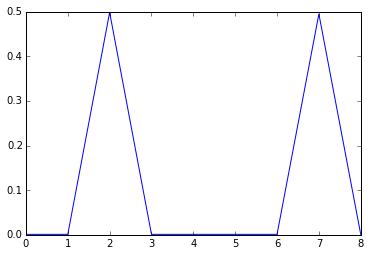

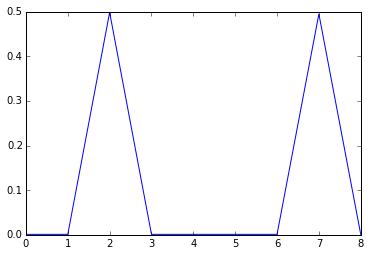

In [570]:
for i in range(10,20):
    plt.plot(range(9),test5[1][i,:]/sum(test5[1][i,:]))
    plt.show()
    raw_input()

In [7]:
%%time
test4 = lda_minibatch(dtm,10,5,50,0.6,10000)

NameError: name 'dtm' is not defined

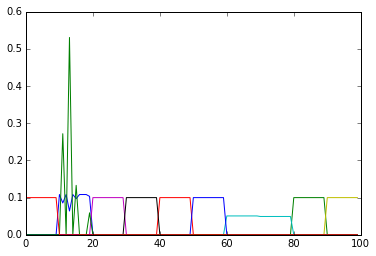

In [433]:
for i in range(10):
    plt.plot(range(100),test4[0][:,i]/sum(test4[0][:,i]))
plt.show()

In [4]:
N_docs = 100
N_words = 450
num_topics = 9
corpus = np.zeros((N_docs, N_words))  # shape (docs, words)
vocabulary = np.arange(N_words)

block = 10 * np.ones((20, 50))
for i in range(num_topics):
    corpus[10*i:10*(i+2),50*i:50*(i+1)] = block

In [295]:
tttt = []
tttt.extend([3,4])

In [296]:
tttt

[3, 4]

In [292]:
%debug

> <ipython-input-290-df773c74cf27>(24)lda_minibatch()
     23             ids = np.nonzero(dtm[doc,:])[0]
---> 24             indices += ids
     25             cts = dtm[doc,ids]

ipdb> print type(indices)
<type 'numpy.ndarray'>
ipdb> print type(ids)
<type 'numpy.ndarray'>
ipdb> q
